<a href="https://colab.research.google.com/github/orhanaydinn/brainTumor-Alzheimer_Prediction/blob/main/BrainTumor_Alzheimer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 - Uploaded Dataset**

In [8]:
import os

# Klasördeki dosyaları listele
print(os.listdir("/content"))

['.config', 'dsadasdas', '.ipynb_checkpoints', 'sample_data']


In [10]:
import zipfile

zip_path = "/content/tumor_alzheimer_dataset.zip"

if zipfile.is_zipfile(zip_path):
    print("✅ This is a valid ZIP file.")
else:
    print("❌ This is NOT a valid ZIP file.")


✅ This is a valid ZIP file.


In [11]:
import zipfile
import os

# Dosya ve çıkarılacak dizin yolları
zip_path = "/content/tumor_alzheimer_dataset.zip"
extract_path = "/content/tumor_alzheimer_dataset"

# ZIP dosyasını aç ve çıkar
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset successfully extracted to:", extract_path)


Dataset successfully extracted to: /content/tumor_alzheimer_dataset


In [12]:
for root, dirs, files in os.walk(extract_path):
    print(f"\n📂 {root}")
    for d in dirs:
        print(f"├── 📁 {d}")
    for f in files[:5]:
        print(f"├── 📄 {f}")


📂 /content/tumor_alzheimer_dataset
├── 📁 tumor_alzheimer_dataset

📂 /content/tumor_alzheimer_dataset/tumor_alzheimer_dataset
├── 📁 alzheimer_moderate_demented
├── 📁 alzheimer_very_mild_demented
├── 📁 alzheimer_non_demented
├── 📁 alzheimer_mild_demented
├── 📁 tumor_no
├── 📁 tumor_yes

📂 /content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/alzheimer_moderate_demented
├── 📄 moderate_6247.jpg
├── 📄 moderate_4514.jpg
├── 📄 moderate_1317.jpg
├── 📄 moderate_1320.jpg
├── 📄 moderate_5477.jpg

📂 /content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/alzheimer_very_mild_demented
├── 📄 very_mild_5079.jpg
├── 📄 very_mild_8440.jpg
├── 📄 very_mild_10948.jpg
├── 📄 very_mild_9005.jpg
├── 📄 very_mild_099.jpg

📂 /content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/alzheimer_non_demented
├── 📄 non_demented_2755.jpg
├── 📄 non_demented_8851.jpg
├── 📄 non_demented_2694.jpg
├── 📄 non_demented_6383.jpg
├── 📄 non_demented_3342.jpg

📂 /content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/alzheimer_

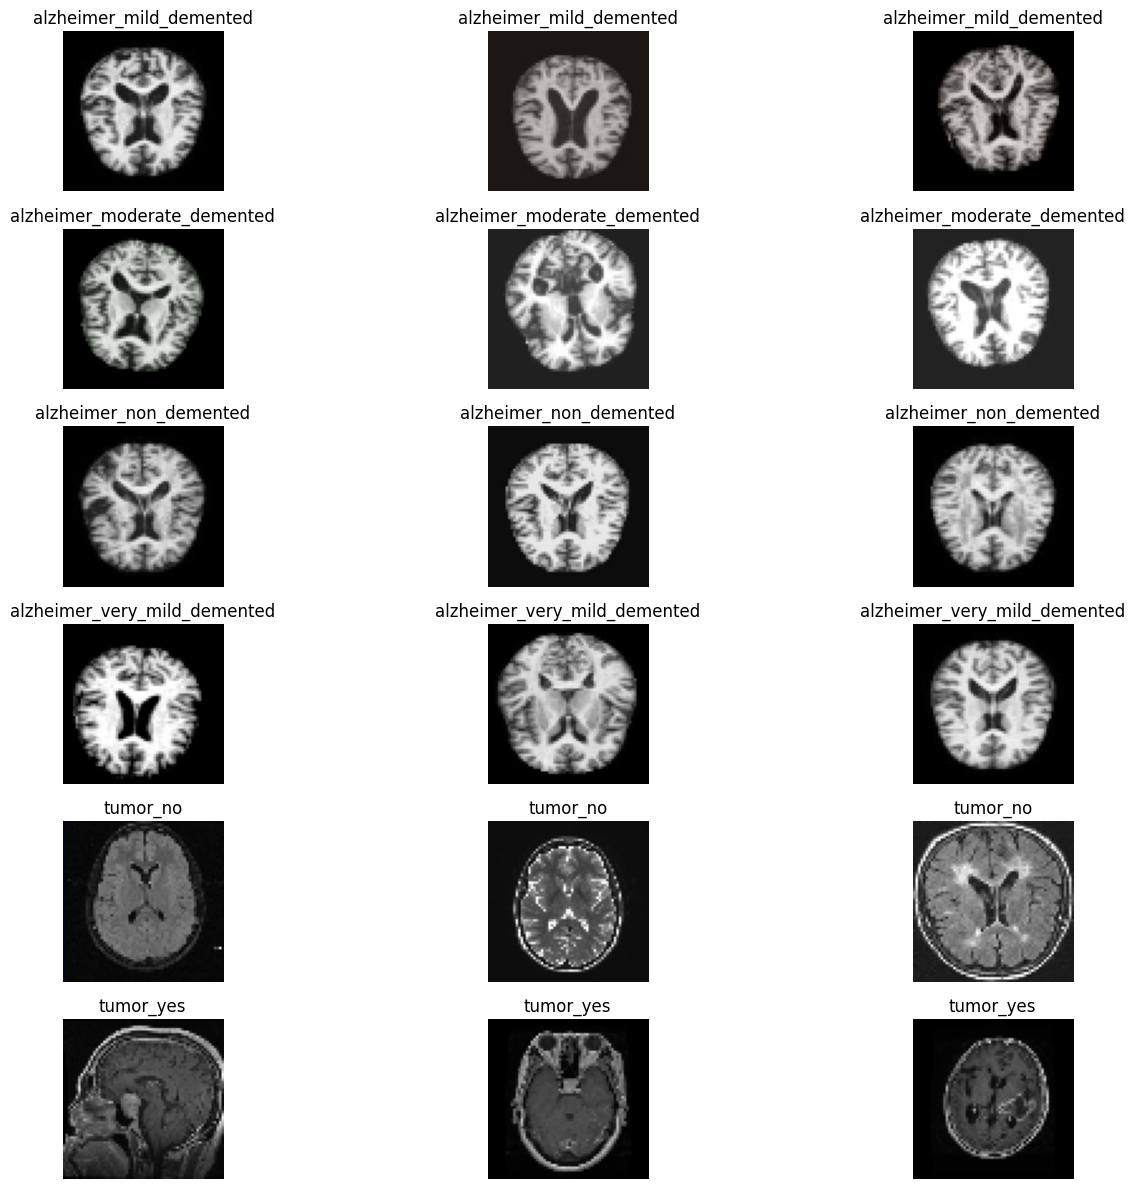

In [13]:
import matplotlib.pyplot as plt
import cv2
import random

IMG_SIZE = 64  # İsteğe göre ayarlanabilir
DATASET_DIR = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset"

# Her sınıftan rastgele 3 görsel göster
def show_random_images(dataset_dir, samples_per_class=3):
    class_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

    plt.figure(figsize=(15, len(class_folders) * 2))
    i = 1
    for label in sorted(class_folders):
        class_path = os.path.join(dataset_dir, label)
        images = os.listdir(class_path)
        random.shuffle(images)

        for img_name in images[:samples_per_class]:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            plt.subplot(len(class_folders), samples_per_class, i)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
            i += 1
    plt.tight_layout()
    plt.show()

show_random_images(DATASET_DIR)

# **2 - Data Preparation & Preprocessing**

## 2.1 - Load and Label Data

In [14]:
import os

# Dataset klasörünü tanımla
DATASET_DIR = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset"

# Sınıf isimlerini al ve etiketle
class_names = sorted(os.listdir(DATASET_DIR))
label_map = {label: idx for idx, label in enumerate(class_names)}
print("Label Mapping:", label_map)

Label Mapping: {'alzheimer_mild_demented': 0, 'alzheimer_moderate_demented': 1, 'alzheimer_non_demented': 2, 'alzheimer_very_mild_demented': 3, 'tumor_no': 4, 'tumor_yes': 5}


## 2.2 - Read, Resize and Convert Images to Arrays

In [15]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 64  # Görselleri boyutlandıracağımız hedef boyut
X = []          # Görsel verileri
y = []          # Etiketler

# Her sınıf için görselleri oku ve işleyerek listeye ekle
for class_name in class_names:
    class_path = os.path.join(DATASET_DIR, class_name)
    label = label_map[class_name]

    for img_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
        img_path = os.path.join(class_path, img_name)

        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR'den RGB'ye dönüşüm
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Yeniden boyutlandırma

            X.append(img)
            y.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")


Processing tumor_yes: 100%|██████████| 6679/6679 [00:10<00:00, 618.37it/s]


## 2.3 - Convert to NumPy Arrays & Normalize the Pixel Values

In [16]:
# Convert lists to NumPy arrays
X = np.array(X, dtype='float32')
y = np.array(y)

# Normalize pixel values to range [0, 1]
X /= 255.0

print("Data converted to NumPy arrays.")
print("X shape:", X.shape)
print("y shape:", y.shape)

Data converted to NumPy arrays.
X shape: (50661, 64, 64, 3)
y shape: (50661,)


## 2.4 - Data Augmentation

### 2.4.1 -  Class Distribution Table

In [17]:
import pandas as pd
from collections import Counter

# Sayıları say
label_counts = Counter(y)
reverse_label_map = {v: k for k, v in label_map.items()}

# DataFrame'e dönüştür
class_distribution_df = pd.DataFrame({
    'Label Index': list(label_counts.keys()),
    'Label Name': [reverse_label_map[i] for i in label_counts.keys()],
    'Image Count': list(label_counts.values())
})

# Sırala ve göster
class_distribution_df = class_distribution_df.sort_values(by='Image Count', ascending=False)
display(class_distribution_df)


,Label Index,Label Name,Image Count
2,2,alzheimer_non_demented,12800
3,3,alzheimer_very_mild_demented,11200
0,0,alzheimer_mild_demented,9856
5,5,tumor_yes,6679
1,1,alzheimer_moderate_demented,6528
4,4,tumor_no,3598


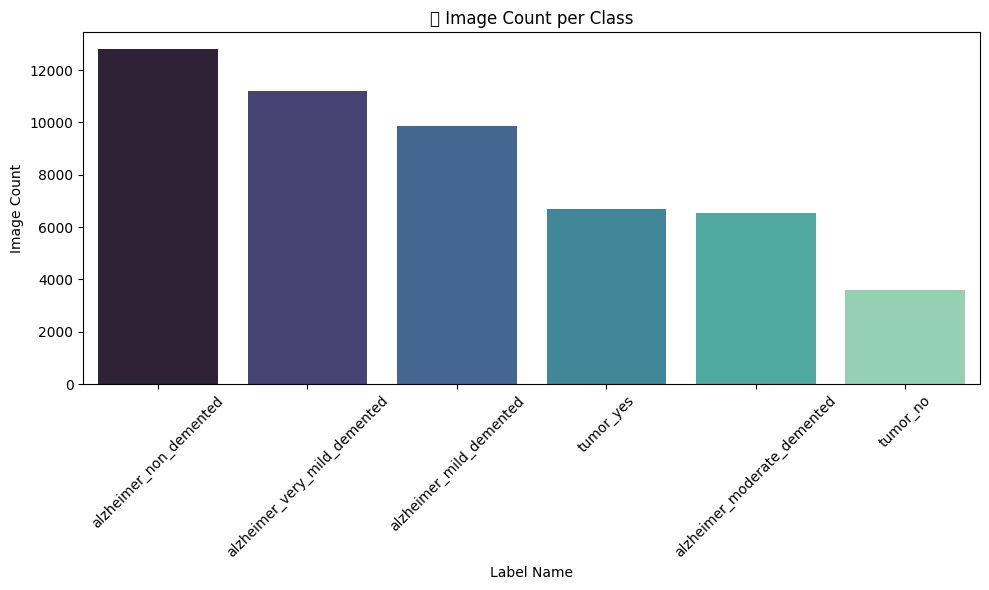

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Uyarıları kapat
warnings.filterwarnings("ignore")

plt.figure(figsize=(10, 6))
sns.barplot(data=class_distribution_df, x="Label Name", y="Image Count", palette="mako")
plt.title("📊 Image Count per Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2.4.2 - Tumor_NO Augmentation

In [19]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation ayarları
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ayarlar
target_count = 9000
input_folder = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/tumor_no"
IMG_SIZE = 64

# Mevcut dosyalar
existing_images = os.listdir(input_folder)
current_count = len(existing_images)
to_generate = target_count - current_count

print(f"📁 Current: {current_count} — Target: {target_count} — Generating: {to_generate}")

# Augmentation işlemi
image_idx = 1
for img_name in tqdm(existing_images):
    img_path = os.path.join(input_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.reshape((1, IMG_SIZE, IMG_SIZE, 3))

    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(2):  # Her resimden 2 tane türet
        if image_idx > to_generate:
            break
        aug_img = next(aug_iter)[0].astype(np.uint8)
        aug_name = f"aug_tumor_no_{image_idx}.jpg"
        cv2.imwrite(os.path.join(input_folder, aug_name), aug_img)
        image_idx += 1

print("✅ Augmentation işlemi tamamlandı.")


📁 Current: 3598 — Target: 9000 — Generating: 5402


100%|██████████| 3598/3598 [00:13<00:00, 266.45it/s] 

✅ Augmentation işlemi tamamlandı.


#### 2.4.2.1 - Show Augmentation Images

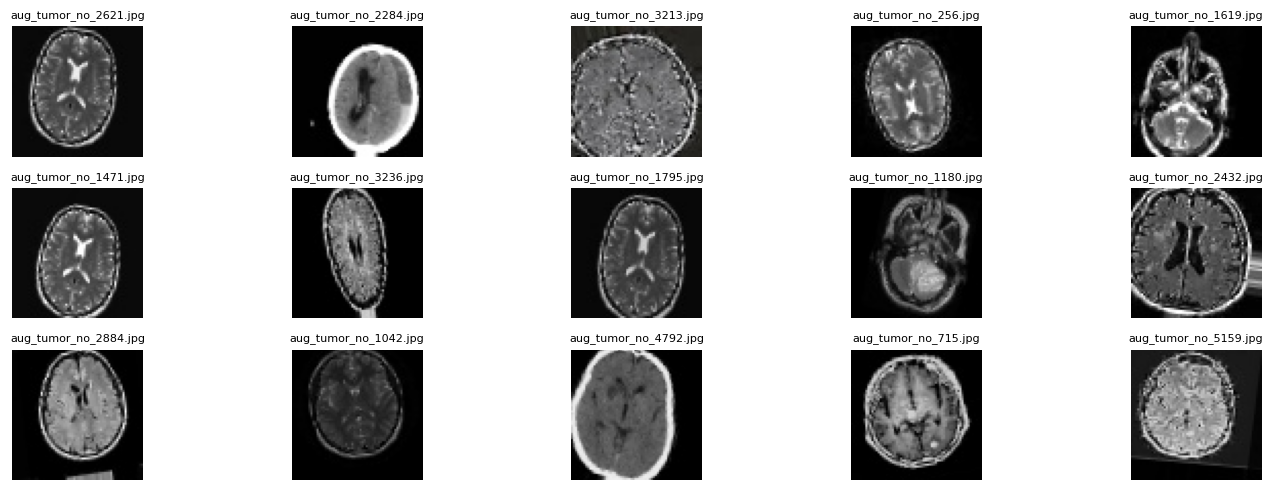

In [20]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Görsellerin bulunduğu klasör
augmented_folder = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/tumor_no"

# Augmented görselleri filtrele
aug_images = [img for img in os.listdir(augmented_folder) if img.startswith("aug_")]

# Rastgele 15 tanesini seç
sample_imgs = random.sample(aug_images, min(15, len(aug_images)))

# Görselleri çizdir
plt.figure(figsize=(15, 5))
for idx, img_name in enumerate(sample_imgs):
    img_path = os.path.join(augmented_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 5, idx + 1)
    plt.imshow(img)
    plt.title(img_name, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


### 2.4.3 - Tumor_YES Augmentation

In [21]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import albumentations as A
from albumentations import (
    RandomBrightnessContrast,
    HorizontalFlip,
    ShiftScaleRotate,
    GaussianBlur
)

# ✅ Paths
input_dir = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/tumor_yes"
output_dir = input_dir  # Aynı klasöre kayıt (istenirse ayrı klasör yapılabilir)
target_count = 10000

# ✅ Var olan dosyaları say
existing_images = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
current_count = len(existing_images)
needed = target_count - current_count

print(f"📁 Current: {current_count} — Target: {target_count} — Generating: {needed}")

# ✅ Augmentation pipeline
transform = A.Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.3),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.4),
    GaussianBlur(blur_limit=3, p=0.2)
])

# ✅ Augmentasyon işlemi
generated = 0
loop_images = existing_images.copy()
while generated < needed:
    for img_name in tqdm(loop_images, desc="Augmenting"):
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = transform(image=image)['image']
        augmented = Image.fromarray(augmented)

        new_name = f"tumor_yes_aug_{generated + 1}.jpg"
        augmented.save(os.path.join(output_dir, new_name))
        generated += 1

        if generated >= needed:
            break

print("✅ Augmentation işlemi tamamlandı.")


📁 Current: 6679 — Target: 10000 — Generating: 3321


Augmenting:  50%|████▉     | 3320/6679 [00:16<00:16, 205.27it/s]

✅ Augmentation işlemi tamamlandı.


#### 2.4.3.1 - Show Augmentation Images

In [22]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Görsellerin bulunduğu klasör
augmented_folder = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/tumor_yes"

# Augmented görselleri filtrele
aug_images = [img for img in os.listdir(augmented_folder) if img.startswith("aug_")]

# Rastgele 15 tanesini seç
sample_imgs = random.sample(aug_images, min(15, len(aug_images)))

# Görselleri çizdir
plt.figure(figsize=(15, 5))
for idx, img_name in enumerate(sample_imgs):
    img_path = os.path.join(augmented_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 5, idx + 1)
    plt.imshow(img)
    plt.title(img_name, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


<Figure size 1500x500 with 0 Axes>

## 2.5 - Show Current Dataset

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset path
DATASET_DIR = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset"

# Sınıf isimlerini al
class_names = sorted([folder for folder in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, folder))])

# Görsel sayılarını hesapla
class_counts = {cls: len([img for img in os.listdir(os.path.join(DATASET_DIR, cls))
                          if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
                for cls in class_names}

# DataFrame oluştur
df_distribution = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
df_distribution = df_distribution.sort_values("Image Count", ascending=False)

# Tabloyu göster
df_distribution.reset_index(drop=True, inplace=True)
df_distribution


,Class,Image Count
0,alzheimer_non_demented,12800
1,alzheimer_very_mild_demented,11200
2,tumor_yes,10000
3,alzheimer_mild_demented,9856
4,tumor_no,9000
5,alzheimer_moderate_demented,6528


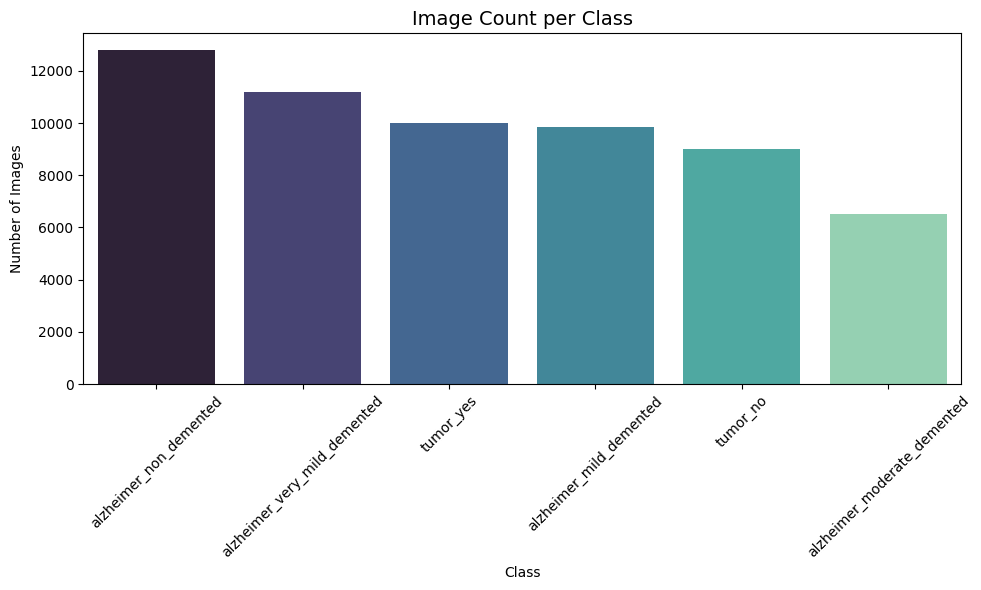

In [24]:
# Bar grafik
plt.figure(figsize=(10, 6))
sns.barplot(data=df_distribution, x="Class", y="Image Count", palette="mako")
plt.title("Image Count per Class", fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# **3 - Model Training & Evaluation**

## 3.1 - Split the Data (Train / Test)

In [25]:
from sklearn.model_selection import train_test_split

X = X / 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

Training Set Shape: (40528, 64, 64, 3)
Test Set Shape: (10133, 64, 64, 3)


## 3.2 - CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN Modeli
cnn_model = Sequential([
    # İlk konvolüsyon katmanı
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # İkinci konvolüsyon katmanı
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Düzleştirme katmanı
    Flatten(),

    # Tam bağlı katman
    Dense(128, activation='relu'),
    Dropout(0.5),  # Overfitting'i azaltmak için dropout

    # Çıkış katmanı (kaç sınıf varsa o kadar nöron)
    Dense(len(np.unique(y)), activation='softmax')  # Çok sınıflı çıktı
])

# Modeli derleme
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 315,206 (1.20 MB)

 Trainable params: 315,206 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

## 3.3 CNN Model Training

In [ ]:
import time

# ⏱️ Zamanlayıcı başlat
start_time = time.time()

# 🧠 Modeli eğit
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,  # veya kullandığın epoch sayısı
    batch_size=32
)

# ⏱️ Zamanlayıcı durdur
end_time = time.time()

# 🕒 Süreyi hesapla
train_duration = end_time - start_time
print(f"⏱️ Training time: {train_duration:.2f} seconds")

Epoch 1/15
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 64s 42ms/step - accuracy: 0.3230 - loss: 1.5323 - val_accuracy: 0.4809 - val_loss: 1.1154
Epoch 2/15
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - accuracy: 0.4578 - loss: 1.1407 - val_accuracy: 0.5010 - val_loss: 1.0374
Epoch 3/15
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - accuracy: 0.4948 - loss: 1.0639 - val_accuracy: 0.5606 - val_loss: 0.9495
Epoch 4/15
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 84s 42ms/step - accuracy: 0.5222 - loss: 1.0033 - val_accuracy: 0.5974 - val_loss: 0.8871
Epoch 5/15
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - accuracy: 0.5648 - loss: 0.9449 - val_accuracy: 0.6289 - val_loss: 0.8160
Epoch 6/15
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 61s 41ms/step - accuracy: 0.5871 - loss: 0.8945 - val_accuracy: 0.6445 - val_loss: 0.7754
Epoch 7/15
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 84s 42ms/step - accuracy: 0.6019 - loss: 0.8580 - val_accuracy: 0.6486 - val_loss: 0.7469
Epoch 8/15
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 80s 41ms/step - accuracy: 0.6098 -

### 3.3.1 Training Visualization

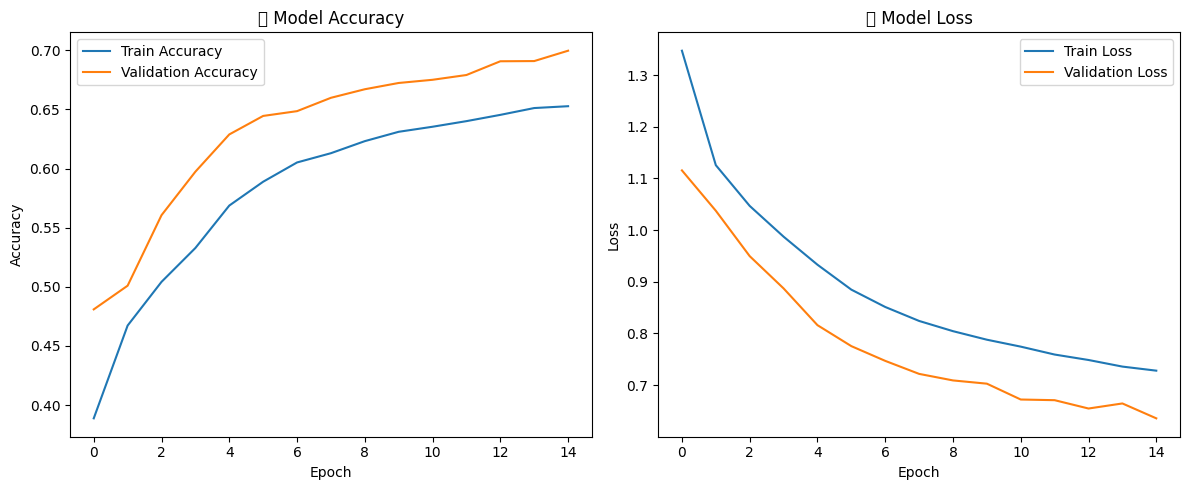

In [ ]:
import matplotlib.pyplot as plt

# Accuracy grafiği
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('📈 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('📉 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 3.4 - MobileNetV2 - Transfer Learning

In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Giriş boyutu
input_shape = (64, 64, 3)

# MobileNetV2'nin ön tanımlı katmanları (ağırlıklar: ImageNet)
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

# Önceden eğitilmiş katmanları donduralım
for layer in base_model.layers:
    layer.trainable = False

# Üst katmanlar
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(6, activation='softmax')(x)  # 6 sınıf için

# Modeli oluştur
mobilenet_model = Model(inputs=base_model.input, outputs=output)

# Derleme
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_mobilenetv2_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Model özeti
mobilenet_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 32, 32, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 32, 32, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 32, 32, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 32, 32, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 32, 32, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 32, 32, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 32, 32, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 32, 32, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 32, 32, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 32, 32, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 32, 32, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 33, 33, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 16, 16, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 3.5 - MobileNetV2 Model Training

In [ ]:
import time

start_time = time.time()

# Modeli eğit
history = mobilenet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"⏱️ Training time: {elapsed_time:.2f} seconds")


Epoch 1/15
1266/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1934 - loss: 2.5464
Epoch 1: val_accuracy improved from -inf to 0.25836, saving model to best_mobilenetv2_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 159s 121ms/step - accuracy: 0.1934 - loss: 2.5460 - val_accuracy: 0.2584 - val_loss: 1.6300
Epoch 2/15
 365/1267 ━━━━━━━━━━━━━━━━━━━━ 1:21 90ms/step - accuracy: 0.2304 - loss: 1.9527